# Model2: Logistic Regression Model TensorFlow

## Import Libraries

In [3]:
import os
import cv2
import random
import numpy as np
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
import sys
sys.path.append('../')

# Import Data in Grayscale

In [4]:
from app import features_vectors

In [5]:
path="../images/train"
x_train,y_train=features_vectors(path,True)
path="../images/test"
x_test,y_test=features_vectors(path,True)

# Visualize Data

## Visualize some random images

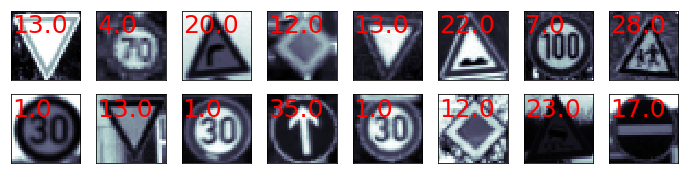

In [6]:
samples = random.sample(range(x_train.shape[0]), 16)
fig=plt.figure(figsize=(12,12))
images_sample=[]
for i,j in enumerate(samples):
    img=x_train[j]
    img=img.reshape(32,32)
    img = img.astype(np.uint8)
    d = fig.add_subplot(8,8, i+1, xticks=[], yticks=[])
    d.imshow(img, cmap=plt.cm.bone)  
    d.text(0,10,str(y_train[j]),color="red",fontsize=25)

Use Randomized_PCA to visualize data estructure 

/home/ncls24/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


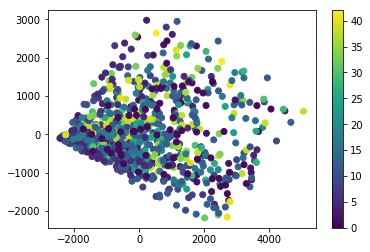

In [7]:
from sklearn.decomposition import RandomizedPCA

pca= RandomizedPCA(n_components=2,random_state=1999)
proj= pca.fit_transform(x_train)
plt.scatter(proj[:,0],proj[:,1],c=y_train)
plt.colorbar()

# Preprocessing Data

# Shuffle Data

In [11]:
from sklearn.utils import shuffle
x_train, y_train = shuffle(x_train, y_train, random_state=100)
x_test, y_test= shuffle(x_test, y_test, random_state=100) 

# Scale Features

In [12]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
x_train=sc.fit_transform(x_train)
x_test=sc.fit_transform(x_test)

## One Hot Encode Target Vector

In [10]:
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder(sparse=False)  
y_train= y_train.reshape(len(y_train), 1) 
y_test= y_test.reshape(len(y_test), 1) 

y_train = onehot_encoder.fit_transform(y_train)
y_test= onehot_encoder.fit_transform(y_test)

# Create and Train model

In [13]:
batch_size = 97



# Input data.

X_Train = tf.placeholder(tf.float32,shape=(batch_size, x_train.shape[1]))
Y_Train = tf.placeholder(tf.float32, shape=(batch_size, y_train.shape[1]))
X_Test = tf.constant(x_test)

# Convert the features vector from  tf.float64 to tf.float32 
X_Train = tf.cast(X_Train, tf.float32)
Y_Train = tf.cast(Y_Train, tf.float32)
X_Test = tf.cast(X_Test, tf.float32)

# Logistic Regression 

w = tf.Variable(tf.truncated_normal([x_train.shape[1], y_train.shape[1]]))
b= tf.Variable(tf.zeros([y_train.shape[1]]),tf.float64)
out = tf.matmul(X_Train, w) + b

# Regularization l2

logits = tf.matmul(X_Train, w) + b
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y_Train))
loss = tf.reduce_mean(loss + 0.001 * tf.nn.l2_loss(w) )


# Optimizer Gradient Descent

#optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
optimizer=tf.train.AdamOptimizer().minimize(loss)


# Predictions 
train_prediction = tf.nn.softmax(out)
test_prediction = tf.nn.softmax(tf.matmul(X_Test, w) + b)
saver = tf.train.Saver()

In [14]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))/ predictions.shape[0]) 

epoch = 8000
with tf.Session() as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(epoch):
   
        offset = (step * batch_size) % (y_train.shape[0] - batch_size)

        batch_data = x_train[offset:(offset + batch_size), :]
        batch_labels = y_train[offset:(offset + batch_size), :]

        feed_dict = {X_Train : batch_data, Y_Train : batch_labels}
        _, l, predictions,t_prediction = session.run([optimizer, loss, train_prediction,test_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("loss %d: %f" % (step, l))
            print("Accuracy batch train data: %.1f%%" % accuracy(predictions, batch_labels))


     
    saver.save(session, '../models/model2/saved/LogisticRegression.ckpt')
    print("Model saved")  

Initialized
loss 0: 75.472748
Accuracy batch train data: 1.0%
loss 500: 21.260118
Accuracy batch train data: 45.4%
loss 1000: 15.034315
Accuracy batch train data: 84.5%
loss 1500: 13.088973
Accuracy batch train data: 89.7%
loss 2000: 11.121962
Accuracy batch train data: 96.9%
loss 2500: 9.309991
Accuracy batch train data: 96.9%
loss 3000: 7.549627
Accuracy batch train data: 97.9%
loss 3500: 5.974238
Accuracy batch train data: 100.0%
loss 4000: 4.574841
Accuracy batch train data: 100.0%
loss 4500: 3.401451
Accuracy batch train data: 100.0%
loss 5000: 2.457428
Accuracy batch train data: 100.0%
loss 5500: 1.724407
Accuracy batch train data: 100.0%
loss 6000: 1.213456
Accuracy batch train data: 100.0%
loss 6500: 0.860273
Accuracy batch train data: 100.0%
loss 7000: 0.643640
Accuracy batch train data: 100.0%
loss 7500: 0.451924
Accuracy batch train data: 100.0%
Model saved


# Evaluate Model

# Training data

In [15]:
X_Train_Accuracy = tf.placeholder(tf.float32,shape=(x_train.shape[0], x_train.shape[1]))

with tf.Session() as sess:
    
    # Restore the model
    saver.restore(sess,'../models/model2/saved/LogisticRegression.ckpt')
    

    # Fetch Back Results
    w_restored,b_restored=sess.run([w,b])
    
    LogisticRegression = tf.matmul(X_Train_Accuracy, w_restored) + b_restored
    out = tf.nn.softmax(LogisticRegression)
    Prediction_restored=sess.run([out],feed_dict={X_Train_Accuracy : x_train})    

INFO:tensorflow:Restoring parameters from ../models/model2/saved/LogisticRegression.ckpt


In [16]:
Prediction_restored=Prediction_restored[0]
matches_train=(np.argmax(Prediction_restored,1)==np.argmax(y_train,1))
accuracy_train=(sum(matches_train)/y_train.shape[0])*100
print("Accuracy with train data",accuracy_train)

Accuracy with train data 98.4536082474227


# Test Data

In [17]:
X_Test_Accuracy = tf.placeholder(tf.float32,shape=(x_test.shape[0], x_test.shape[1]))

with tf.Session() as sess:
    
    # Restore the model
    saver.restore(sess,'../models/model2/saved/LogisticRegression.ckpt')
    

    # Fetch Back Results
    w_restored,b_restored=sess.run([w,b])
    
    LogisticRegression = tf.matmul(X_Test_Accuracy, w_restored) + b_restored
    out = tf.nn.softmax(LogisticRegression)
    Prediction_restored=sess.run([out],feed_dict={X_Test_Accuracy : x_test})   

INFO:tensorflow:Restoring parameters from ../models/model2/saved/LogisticRegression.ckpt


In [18]:
Prediction_restored=Prediction_restored[0]
matches_test=(np.argmax(Prediction_restored,1)==np.argmax(y_test,1))
accuracy_test=(sum(matches_test)/y_test.shape[0])*100
print("Accuracy with train data",accuracy_test)

Accuracy with train data 68.72427983539094


I think that I have mixed the data with an incorrect distribution of samples for the training and test data, as a consequence obtaining a low accuracy with the test data.

I Believe that the developed algorithm would improve with an algorithm of extraction of characteristics and adjustment in the parameters of the model but I do not have sufficient background in Tensorflow and opencv or another library of image processing for its optimization

# Visualize Predictions

In [19]:
dic_labels={0: '0',1: '1',2: '2',3: '3',4: '4',5: '5',6: '6',7: '7',8: '8',9: '9',\
        10: '10',11: '11',12: '12',13: '13',14: '14',15: '15',16: '16',17: '17',\
        18: '18',19: '19',20: '20',21: '21',22: '22',23: '23',24: '24',25: '25',\
        26: '26',27: '27',28: '28',29: '29',30: '30',31: '31',32: '32',33: '33',\
        34: '34',35: '35',36: '36',37: '37',38: '38',39: '39',40: '40',41: '41',\
        42: '42'}

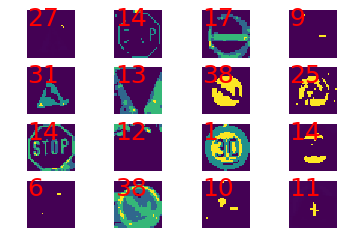

In [27]:
def visualize_predictions(dataset, labels):
  dataset=sc.inverse_transform(dataset)
  labels=np.argmax(labels, 1)
  items = random.sample(range(len(labels)), 16)
  for i, item in enumerate(items):
    plt.subplot(4, 4, i+1)
    plt.axis('off')
    plt.text(0,10,dic_labels[labels[item]],color="red",fontsize=25)
    img=dataset[item]
    img=img.reshape(32,32)
    img = img.astype(np.uint8)
    plt.imshow(img)

pred=np.round(predictions)   
visualize_predictions(batch_data,pred)